# Templatematching beide Seiten

https://www.open3d.org/html/tutorial/pipelines/icp_registration.html

- point to plain ist meist etwas langsamer, müssen erst normals berechnet werden
- threshold 0.02 funktioniert zumindest bei Punkten oben (0.2 nicht)
- zentrum des Clusterpaars ist nicht geeignet: bei Lücke ist es sehr stark verschoben
- translation init_transform
    - Wenn Punkte oben auf der Schiene, dann z am besten im Zentrum; mit translation nach oben funktioniert es nicht mehr gut
    - Wenn Punkte auf Seite, dann umgekehrt: translation nach oben führt zu OK match, ansonsten matcht es meist an der falschen Stelle
    - trotzdem nur halbwegs gut
        - z.B. matcht die Innenseite des Stegs gegen die eigentliche Außenseite und am Kopf entsprechend verrutscht
    - transform mit max z funktioniert bei "PunkteOben" nicht richtig, template landet viel zu hoch!?
- Braucht zwischen 0.1 und 0.5 s
    - Das wäre mehr als eine Minute pro Datei (0.4 * 200 = 80) STIMMT NICHT, nicht 200 Paare
    - Mein System braucht (incl. Clustering und PCA) knapp unter 0.01 s pro Punkt, das wären 2s bei 200 Punkten

In [1]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import json
import time 
import matplotlib.pyplot as plt
import copy

import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten


ogr.UseExceptions()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
gauge = 1.435
railhead_width = 0.067

In [3]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

In [4]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [5]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax
    

In [6]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, percentile=95, railhead_width = 0.067, centering="cluster"): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        eigenvects (np.array): Eigenvectors of the PCA of the pair of clusters
        percentile (int): Percentile of the height for the horizontal line
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)

    if centering == "cluster":
        cluster = cluster - center_cluster
        cluster_other = cluster_other - center_other
    else:
        cluster = cluster - center
        cluster_other = cluster_other - center

    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    #print("center", center)
    #print(center_cluster - center, center_other - center)
    #print((center_cluster - center) @ transformmatrix, (center_other - center) @ transformmatrix)


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        #print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    if centering == "cluster":
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_ylim(-0.08, 0.06)
    else:
        ax[0].set_xlim(-0.85, -0.65)
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_xlim(0.65, 0.85)
        ax[1].set_ylim(-0.08, 0.06)
        ax[0].axvline(-gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[0].axvline(-gauge/2 - railhead_width, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2 + railhead_width, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")

    x_mean = transformed[:,0].mean()
    ax[0].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(np.percentile(transformed[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axhline(transformed[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    x_mean = transformed_other[:,0].mean()
    ax[1].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(np.percentile(transformed_other[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axhline(transformed_other[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    plt.show()
    return fig, ax, transformed, transformed_other




In [7]:
def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(sidevector_perpendicular, eigenvects.T[0]) 

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    if normal[2] < 0:
        # print("Upside down")
        Rx_180 = np.array([
            [1,  0,  0],
            [0, -1,  0],
            [0,  0, -1]
        ])
        # Data in row vector, this is first the main rotation, than the rotation around the y axis
        matrix = matrix @ Rx_180 

    return matrix

In [8]:
def draw_registration_result(source, target, transformation):
    axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp, axes])


In [9]:
def load_clusters(preset):
    fileleft = f"clusterbeispiele/{preset}_l.ply"
    fileright = f"clusterbeispiele/{preset}_r.ply"
    filepair = f"clusterbeispiele/{preset}_pair.ply"
    if not os.path.exists(fileleft):
        raise FileNotFoundError(f"File {fileleft} not found")
    cluster = o3d.io.read_point_cloud(fileleft)
    cluster_other = o3d.io.read_point_cloud(fileright)
    cluster_pair = o3d.io.read_point_cloud(filepair)
    return np.asarray(cluster.points) , np.asarray(cluster_other.points), np.asarray(cluster_pair.points)

In [10]:
def get_o3d_transform(eigenvects, translation=None):
    """Create an open3d 4x4 transformation matrix from eigenvectors
    
    Version für 2 Schienen
    """
    eigenvects = eigenvects.copy()

    # Check if the last eigenvector is pointing down
    if eigenvects[2,2] < 0: # z of last eigenvector is negative
        print("o3d trans was Upside down")
        # reflect
        eigenvects[:,2] *= -1 # reflection 

    # There is a 50% chance that det(eigenvects) is close to -1
    # (then the matrix includes a reflection)
    if np.linalg.det(eigenvects) < 0:
        # flip the first eigenvector
        eigenvects[:,0] *= -1


    transform = np.eye(4)
    transform[0:3, 0:3] = eigenvects

    if translation is not None:
        transform[:3, 3] = translation
    return transform

In [11]:
templatefiles = [
    "T_profil_ähnlich_54E4.ply", 
    "T_profil_ähnlich_54E4_schräg_random2.ply",
    "T_profil_ähnlich_54E4_schräg_random_wenig_punkte.ply"
    ]

In [12]:
def get_template(filename):
    shift = (gauge + railhead_width) / 2
    pcd = o3d.io.read_point_cloud(os.path.join("templates", filename))
    left = np.asarray(pcd.points)
    right = left.copy()
    left[:,0] -= shift
    right[:,0] += shift

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.vstack((left, right)))
    return pcd

In [13]:
4.7e-2

0.047

In [14]:
threshold = 0.02 #05


In [15]:
preset = "PunkteSeiteVieleAusreisser"
preset = "ObenundSeite" # In Wirklichkeit nur oben
preset = "ObenNull1"
preset = "PunkteSeite"
preset = "VieleLückeMitte"
preset = "VieleGleiseEherTop" # Übergang
preset = "VieleSchürhaken"
preset = "VieleZ" # Fast nur auf Seite, schrott


translations = [None, np.array([0, 0, 0.03])]

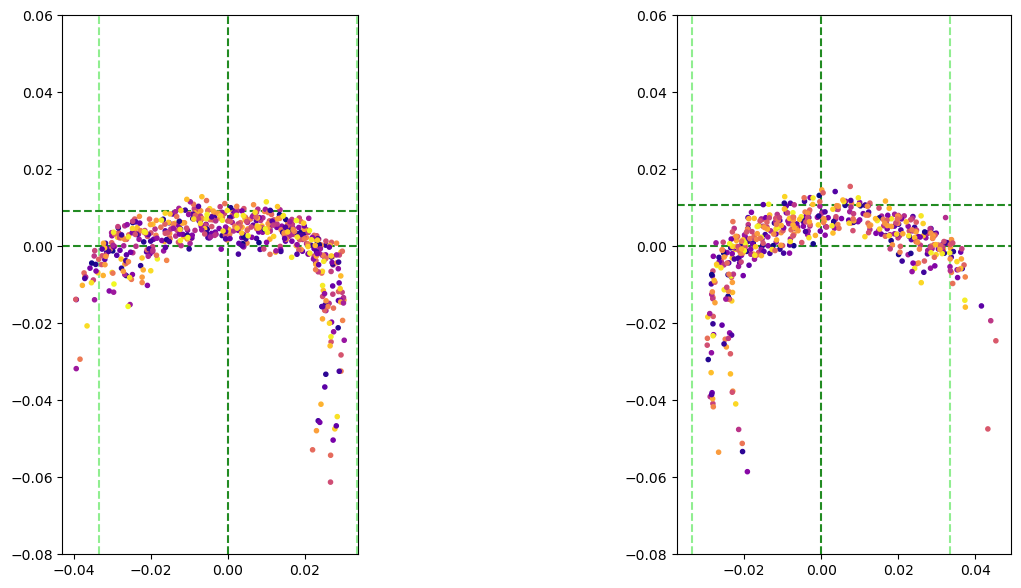

T_profil_ähnlich_54E4.ply


In [39]:
preset = "ObenNull"
templatenr = 0
translation = translations[1]

templatefile = templatefiles[templatenr]

cluster_this, cluster_other, cluster_pair = load_clusters(preset)
_, eigenvects = pca(cluster_this)
plottransform = get_transformmatrix(cluster_this, cluster_other, cluster_this.mean(axis=0), cluster_other.mean(axis=0), eigenvects)
plot_cluster_pair(cluster_this, cluster_other, plottransform, percentile=95, railhead_width = 0.067, centering="cluster");
print(templatefile)

In [40]:
_, eigenvects = pca(cluster_pair)

# center = cluster_pair.mean(axis=0) # Funktioniert nicht bei Lücke 
center = get_central_point(cluster_this.mean(axis=0), cluster_other.mean(axis=0))
centered = cluster_pair - center

centered_pcd = o3d.geometry.PointCloud()
centered_pcd.points = o3d.utility.Vector3dVector(centered)

print("Translation", translation)
trans_init = get_o3d_transform(eigenvects, translation)

target = centered_pcd
source = get_template(templatefile)

print("Evaluate initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

if translation is None:
    tr_string = "None"
else:
    tr_string = str(translation[2])

draw_registration_result(source, target, trans_init)

Translation [0.   0.   0.03]
o3d trans was Upside down
Evaluate initial alignment
RegistrationResult with fitness=2.192763e-01, inlier_rmse=1.381130e-02, and correspondence_set size of 3333
Access transformation to get result.


In [41]:
eigenvects  

array([[-9.66206143e-01,  2.57759720e-01,  2.36988601e-03],
       [-2.57761717e-01, -9.66208345e-01, -5.74811173e-04],
       [-2.14164047e-03,  1.16625197e-03, -9.99997027e-01]])

In [42]:
trans_init   

array([[-9.66206143e-01,  2.57759720e-01, -2.36988601e-03,
         0.00000000e+00],
       [-2.57761717e-01, -9.66208345e-01,  5.74811173e-04,
         0.00000000e+00],
       [-2.14164047e-03,  1.16625197e-03,  9.99997027e-01,
         3.00000000e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

### Point to Point ICP

In [43]:
threshold  

0.02

In [44]:
start = time.time()
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
print("Time:", time.time() - start)

print(f"{preset}_t{templatenr}_zTransf{tr_string}_point")

draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP


RegistrationResult with fitness=3.651316e-01, inlier_rmse=1.198631e-02, and correspondence_set size of 5550
Access transformation to get result.
Transformation is:
[[-9.66487945e-01  2.56703202e-01 -2.12541267e-03  9.18008103e-04]
 [-2.56705369e-01 -9.66489364e-01  8.13782986e-04 -2.68338528e-04]
 [-1.84528804e-03  1.33211629e-03  9.99997410e-01  7.06898454e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Time: 0.44870734214782715
ObenNull_t0_zTransf0.03_point


### Point to Plane ICP

In [45]:
start = time.time()
print("Apply point-to-plane ICP")

# Point-to-plane ICP requires normals for the target
nn_distance = np.mean(target.compute_nearest_neighbor_distance())  
print("nn distance", nn_distance)  
  
#setting the radius search to compute normals  
radius_normals=nn_distance*4  
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  

reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("Time:", time.time() - start)
print(f"{preset}_t{templatenr}_{tr_string}_plane")
draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP
nn distance 0.006414877053516488
RegistrationResult with fitness=3.573684e-01, inlier_rmse=1.197731e-02, and correspondence_set size of 5432
Access transformation to get result.
Transformation is:
[[-9.62054048e-01  2.72846505e-01 -2.60633334e-03  1.62524109e-03]
 [-2.72847050e-01 -9.62057412e-01 -1.51105647e-04 -4.06561578e-03]
 [-2.54867096e-03  5.65758564e-04  9.99996592e-01  5.39277675e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Time: 0.5328793525695801
ObenNull_t0_0.03_plane


## Point to Plane, target source vertauscht

In [46]:
eigenvects

array([[-9.66206143e-01,  2.57759720e-01,  2.36988601e-03],
       [-2.57761717e-01, -9.66208345e-01, -5.74811173e-04],
       [-2.14164047e-03,  1.16625197e-03, -9.99997027e-01]])

In [47]:
source = centered_pcd
target = get_template(templatefile)
translation2 = translation
if translation2 is not None:
    translation2 = -translation2
trans_init2 = get_o3d_transform(eigenvects.T, translation2)

print("Evaluate initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init2)
print(evaluation)

target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  
draw_registration_result(source, target, trans_init2)

o3d trans was Upside down
Evaluate initial alignment
RegistrationResult with fitness=3.797814e-01, inlier_rmse=1.250666e-02, and correspondence_set size of 417
Access transformation to get result.


In [48]:
start = time.time()
print("Apply point-to-plane ICP, Source = Cluster, Target = Template")

# Point-to-plane ICP requires normals for the target
nn_distance = np.mean(target.compute_nearest_neighbor_distance())  
print("nn distance", nn_distance)  
  
#setting the radius search to compute normals  
radius_normals=nn_distance*4  
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  


# loss = o3d.pipelines.registration.HuberLoss(k=0.05)


reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init2,
    o3d.pipelines.registration.TransformationEstimationPointToPlane(
       # loss
        ))
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("Time:", time.time() - start)
print(f"{preset}_t{templatenr}_{tr_string}_plane_vertauscht")
draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP, Source = Cluster, Target = Template
nn distance 0.0049999999999999975
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[-9.66427709e-01 -2.56638952e-01 -1.24068978e-02  9.37801790e-05]
 [ 2.56687624e-01 -9.66491246e-01 -2.47706269e-03 -2.66246328e+08]
 [-1.13554473e-02 -5.57859914e-03  9.99919963e-01 -1.67819234e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Time: 0.11873960494995117
ObenNull_t0_0.03_plane_vertauscht


Threshold 0.02


Clusterpaar|Template|None Point|None Plain|0.03 Point|0.03 Plain|None PlaneV|0.03 PlaneV
---|:---:|---:|---:|---:|---:|---:|---: 
ObenNull1|0|2|2|2|2|2|0
ObenNull1|1|2|2|2|2|2|0
ObenNull1|2|2|2|2|2|2|0
ObenundSeite|0|2|2|2|2|2|0
ObenundSeite|1|2|2|2|2|2|0
ObenundSeite|2|2|2|2|2|2|0
VieleGleiseEherTop|0|2|2|2|2|2|2
VieleGleiseEherTop|1|2|2|2|2|2|0
VieleGleiseEherTop|2|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|0|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|1|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|2|0|0|2|2|2|2
PunkteSeite|0|2|0|2|2|2|2
PunkteSeite|1|2|0|2|2|2|2
PunkteSeite|3|0|0|2|2|2|2
VieleSchürhaken|0|0|0|2|2|2|2
VieleSchürhaken|1|0|0|2|2|2|2
VieleSchürhaken|2|0|0|0|0|0|0
VieleZ|0|0|0|2|0
VieleZ|1|0|0|2|0
VieleZ|0|0|0|2|2
VieleLückeMitte|0|0|0|1|0|0|0
VieleLückeMitte|1|0|0|0|0|0|0
VieleLückeMitte|2|0|0|0|0|0|0


Bei t1 plane vertauscht verrutscht

- threshold: Wenn Abstand nächster Nachbar größer, dann Punkt = Outlier, ignorieren
- init transform: wenn threshold zu klein, findet ICP die richtige Richtung nicht
- Problem: Punkte sehr eng entlang Scanlinien, aber Scanlinien weit auseinander
- RMSE wird nur auf den Inliern berechnet
    - hängt von threshold und dem Abstand der Scanlinien ab!
    - wenn Template = Source: Inlier = Alle Punkte im Template mit Abstand kleiner threshold, Löcher im Netz der Scanlinien
    - rmse ist immer ungefähr in der Größenordnung wie der Abstand der Scanlinien
    - daher wenig aussagekräftig
- fitness = Anz. Inlier / Anz. Points in Target
    - Wenn Target= Cluster, dann hängt das stark von Länge des Clusters ab
- Idee: 
    - ICP mit Template als Source scheint besser zu funktionieren
    - Aber RMSE und Fitness andersrum macht mehr Sinn und das kann anschließend gemacht werden:
        - dann mit kleinem Threshold möglich
        - jeder Punkt im Cluster sollte einen nahen Punkt im Template haben
        - Dabei muss die inverse Transformationsmatrix an `o3d.pipelines.registration.evaluate_registration` übergeben werden  
        - Allerdings ist fitness dann nicht aussagekräftig (Cluster kann viel länger als Template sein) 